# Modelling & Evaluation
3 regression models will be used to try and predict housing prices in Ames, Iowa, based on the complete train dataset containing selected features that was cleaned and exported in the previous notebook.

### Contents
- [Preprocessing](#Preproccessing)
- [Regression Modelling](#Regression-Modelling)
- [Evaluation](#Evaluation)
- [Kaggle Submission](#Kaggle-Submission)
- [Conclusion](#Conclusion)

## Import Libraries

In [1]:
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.dummy import DummyRegressor

In [2]:
# Set max rows and columns display
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 20)

## Preprocessing

In [3]:
# import the dataset
train = pd.read_csv('datasets/train_cleaned_eda.csv')
X = train.drop('saleprice', axis=1)
y = train['saleprice']

### One Hot Encoding
Categorical variables need to be encoded into dummy variables before they can be processed by the regression models. Here, we fit and transform the categorical variables in the complete test dataset first. The instantiated ohe can then be used to transform the test dataset later.

In [4]:
feature_names = list(X.columns.values)
print(feature_names)

['neighborhood', 'garage_type', 'lot_area', 'house_age', 'overall_qual', 'gr_liv_area', 'kitchen_qual', 'garage_area', 'total_bsmt_sf', 'bsmt_qual']


In [5]:
# define list of categorical features
X_categorical = list(train.select_dtypes(include=['object']).columns)
X_categorical

['neighborhood', 'garage_type']

In [6]:
# Use OneHotEncoder
# instantiate the OHE
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

# fit OHE to features
ohe.fit(X[X_categorical])

# create dummy array
transformed = ohe.transform(X[X_categorical])

# input column names
column_name = ohe.get_feature_names_out(X_categorical)

# rebuild dataframe and drop redundant columns
X = pd.concat([X, pd.DataFrame(transformed, columns=column_name)], axis=1)
X.drop(X_categorical, axis=1, inplace=True)
X.head()

,lot_area,house_age,overall_qual,gr_liv_area,kitchen_qual,garage_area,total_bsmt_sf,bsmt_qual,neighborhood_Blmngtn,neighborhood_Blueste,neighborhood_BrDale,neighborhood_BrkSide,neighborhood_ClearCr,neighborhood_CollgCr,neighborhood_Crawfor,neighborhood_Edwards,neighborhood_Gilbert,neighborhood_Greens,neighborhood_GrnHill,neighborhood_IDOTRR,neighborhood_Landmrk,neighborhood_MeadowV,neighborhood_Mitchel,neighborhood_NAmes,neighborhood_NPkVill,neighborhood_NWAmes,neighborhood_NoRidge,neighborhood_NridgHt,neighborhood_OldTown,neighborhood_SWISU,neighborhood_Sawyer,neighborhood_SawyerW,neighborhood_Somerst,neighborhood_StoneBr,neighborhood_Timber,neighborhood_Veenker,garage_type_2Types,garage_type_Attchd,garage_type_Basment,garage_type_BuiltIn,garage_type_CarPort,garage_type_Detchd,garage_type_none
0,13517,34,6,1479,4,475.0,725.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,11492,13,7,2122,4,559.0,913.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,7922,57,5,1057,4,246.0,1057.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,9802,4,5,1444,3,400.0,384.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,14235,110,6,1445,3,484.0,676.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [7]:
X.shape

(2051, 43)

### Train/Test Split
The complete train dataset (X & y) will now be split into a smaller training set (X_train & y_train) and a holdout set (X_valid & y_valid) to be used for valiating our models (so named to prevent confusion with the actual kaggle test dataset).

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.75, random_state=42)

In [9]:
# check that the number of columns are equal
print(f'Number of columns for X_train is {X_train.shape[1]}')
print(f'Number of columns for X_valid is {X_valid.shape[1]}')

Number of columns for X_train is 43
Number of columns for X_valid is 43


### Scaling
Scale features for lasso and ridge regression. Fit `StandardScaler` to `X_train` and use it to transform both `X_train` and `X_valid`

In [10]:
ss = StandardScaler() # instantiate
ss = ss.fit(X_train) # fit to the train set
Xs_train = ss.transform(X_train)
Xs_valid = ss.transform(X_valid)

### Null Model (Baseline)

In [11]:
# makes getting RMSE scores from cross val easier
get_rmse = make_scorer(mean_squared_error, squared=False)

In [12]:
# generate the null model
dr = DummyRegressor(strategy="mean") # instantiate DummyRegressor with strategy "mean"
dr.fit(Xs_train, y_train) # fit to the train data
dr_r2 = cross_val_score(dr, Xs_train, y_train, cv=5).mean()
dr_rmse = cross_val_score(dr, Xs_train, y_train, cv=5, scoring=get_rmse).mean()

print(f"Dummy Regression CV R2: {dr_r2}")
print(f"Dummy Regression CV RMSE: {dr_rmse}")

Dummy Regression CV R2: -0.0009377481689546663
Dummy Regression CV RMSE: 79298.96457527815


## Regression Modelling

### Linear Regression

In [13]:
# instantiate the model
lr = LinearRegression()

lr.fit(Xs_train, y_train)
lr_score = lr.score(Xs_train, y_train)

print(f"Linear Regression train R2: {lr_score}")

Linear Regression train R2: 0.8354162230885589


In [14]:
# cross validation of ridge scores
lr_cv_r2 = cross_val_score(lr, Xs_train, y_train, cv=5).mean()
lr_cv_rmse = cross_val_score(lr, Xs_train, y_train, cv=5, scoring=get_rmse).mean()

print(f"Linear Regression CV R2: {lr_cv_r2}")
print(f"Linear Regression CV RMSE: {lr_cv_rmse}")

Linear Regression CV R2: -7.482097271749261e+20
Linear Regression CV RMSE: 1156932808914771.5


In [15]:
# evaluation against validation set
lr_pred = lr.predict(Xs_valid)

lr_r2 = r2_score(y_valid, lr_pred)
lr_rmse = mean_squared_error(y_valid, lr_pred, squared=False)

print(f"Linear Regression R2: {lr_r2}")
print(f"Linear Regression RMSE: {lr_rmse}")

Linear Regression R2: 0.8518819711014542
Linear Regression RMSE: 30157.061535268618


### Ridge Regression

In [16]:
# search for the best alpha
r_alphas = np.logspace(0, 5, 100)
ridge_cv = RidgeCV(alphas=r_alphas)
ridge_cv.fit(Xs_train, y_train)

RidgeCV(alphas=array([1.00000000e+00, 1.12332403e+00, 1.26185688e+00, 1.41747416e+00,
       1.59228279e+00, 1.78864953e+00, 2.00923300e+00, 2.25701972e+00,
       2.53536449e+00, 2.84803587e+00, 3.19926714e+00, 3.59381366e+00,
       4.03701726e+00, 4.53487851e+00, 5.09413801e+00, 5.72236766e+00,
       6.42807312e+00, 7.22080902e+00, 8.11130831e+00, 9.11162756e+00,
       1.02353102e+01, 1.14975700e+0...
       6.89261210e+03, 7.74263683e+03, 8.69749003e+03, 9.77009957e+03,
       1.09749877e+04, 1.23284674e+04, 1.38488637e+04, 1.55567614e+04,
       1.74752840e+04, 1.96304065e+04, 2.20513074e+04, 2.47707636e+04,
       2.78255940e+04, 3.12571585e+04, 3.51119173e+04, 3.94420606e+04,
       4.43062146e+04, 4.97702356e+04, 5.59081018e+04, 6.28029144e+04,
       7.05480231e+04, 7.92482898e+04, 8.90215085e+04, 1.00000000e+05]))

In [17]:
# best alpha
ridge_cv.alpha_

187.3817422860383

In [18]:
# cross validation ridge scores
ridge = Ridge(alpha=ridge_cv.alpha_) # instantiate
ridge_cv_r2 = cross_val_score(ridge, Xs_train, y_train, cv=5).mean()
ridge_cv_rmse = cross_val_score(ridge, Xs_train, y_train, cv=5, scoring=get_rmse).mean()

print(f"Ridge Regression CV R2: {ridge_cv_r2}")
print(f"Ridge Regression CV RMSE: {ridge_cv_rmse}")

Ridge Regression CV R2: 0.8128766111803282
Ridge Regression CV RMSE: 33924.89179274799


In [19]:
# evaluation against validation set
ridge.fit(Xs_train, y_train)
ridge_pred = ridge.predict(Xs_valid)

ridge_r2 = r2_score(y_valid, ridge_pred)
ridge_rmse = mean_squared_error(y_valid, ridge_pred, squared=False)
                          
print(f"Ridge Regression R2: {ridge_r2}")
print(f"Ridge Regression RMSE: {ridge_rmse}")

Ridge Regression R2: 0.8544722029167222
Ridge Regression RMSE: 29892.210909181595


### Lasso Regression

In [20]:
# search for the best alpha
optimal_lasso = LassoCV(n_alphas=100, cv=5) # instantiate
optimal_lasso.fit(Xs_train, y_train)

LassoCV(cv=5)

In [21]:
# best alpha
optimal_lasso.alpha_

96.19317030475823

In [22]:
# cross validation lasso scores
lasso = Lasso(alpha=optimal_lasso.alpha_) # instantiate
lasso_cv_r2 = cross_val_score(lasso, Xs_train, y_train, cv=5).mean()
lasso_cv_rmse = cross_val_score(lasso, Xs_train, y_train, cv=5, scoring=get_rmse).mean()

print(f"Lasso Regression CV R2: {lasso_cv_r2}")
print(f"Lasso Regression CV RMSE: {lasso_cv_rmse}")

Lasso Regression CV R2: 0.810382182089851
Lasso Regression CV RMSE: 34066.699984911844


In [23]:
# evaluation against validation set
lasso.fit(Xs_train, y_train)
lasso_pred = lasso.predict(Xs_valid)

lasso_r2 = r2_score(y_valid, lasso_pred)
lasso_rmse = mean_squared_error(y_valid, lasso_pred, squared=False)

print(f"Lasso Regression R2: {lasso_r2}")
print(f"Lasso Regression RMSE: {lasso_rmse}")

Lasso Regression R2: 0.8530366603436145
Lasso Regression RMSE: 30039.283279387517


## Evaluation

The results of modelling are as follows:

|Model|Cross-Validation RMSE|Cross-Validation R2|
|:---|---:|---:|
|Dummy|79298|-0.0009|
|Linear|6.0132|-3.522e+24|
|**Ridge**|0.8129|33924|
|Lasso|0.8104|34066|

The Ridge and Lasso models performed significantly better than the null and Linear Regression models, with Ridge edging out Lasso by a tiny bit. Regularization regression models shrink the regression coefficients, effectively removing features that do not contribute much to the predictive value of the model. Of note is that Lasso is slightly more aggressive than Ridge and is capable zeroing noise variables. These models prevent overfitting by reducing variance. In light of the results, Lasso and Ridge likely succeeded in removing noise from the vanilla Linear Regression model.<br>

`Ridge` model currently has the lowest RMSE and highest R2 based on our train data, suggesting that it is the most optimal model among the 3. We will be evaluating the the 3 models using the full train dataset against the kaggle test dataset.

## Kaggle Submission

### Applying Same Cleaning and Transformation to Kaggle Test Dataset

In [24]:
# Import test
test = pd.read_csv('datasets/test.csv')

In [25]:
# Checking it out
test.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,2fmCon,2Story,6,8,1910,1950,Gable,CompShg,AsbShng,AsbShng,None,0.0,TA,Fa,Stone,Fa,TA,No,Unf,0,Unf,0,1020,1020,GasA,Gd,N,FuseP,908,1020,0,1928,0,0,2,0,4,2,Fa,9,Typ,0,NaN,Detchd,1910.0,Unf,1,440,Po,Po,Y,0,60,112,0,0,0,NaN,NaN,NaN,0,4,2006,WD
1,2718,905108090,90,RL,NaN,9662,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,Duplex,1Story,5,4,1977,1977,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,CBlock,Gd,TA,No,Unf,0,Unf,0,1967,1967,GasA,TA,Y,SBrkr,1967,0,0,1967,0,0,2,0,6,2,TA,10,Typ,0,NaN,Attchd,1977.0,Fin,2,580,TA,TA,Y,170,0,0,0,0,0,NaN,NaN,NaN,0,8,2006,WD
2,2414,528218130,60,RL,58.0,17104,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,7,5,2006,2006,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,Gd,Av,GLQ,554,Unf,0,100,654,GasA,Ex,Y,SBrkr,664,832,0,1496,1,0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,2006.0,RFn,2,426,TA,TA,Y,100,24,0,0,0,0,NaN,NaN,NaN,0,9,2006,New
3,1989,902207150,30,RM,60.0,8520,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,1Story,5,6,1923,2006,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,Gd,TA,CBlock,TA,TA,No,Unf,0,Unf,0,968,968,GasA,TA,Y,SBrkr,968,0,0,968,0,0,1,0,2,1,TA,5,Typ,0,NaN,Detchd,1935.0,Unf,2,480,Fa,TA,N,0,0,184,0,0,0,NaN,NaN,NaN,0,7,2007,WD
4,625,535105100,20,RL,NaN,9500,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1963,1963,Gable,CompShg,Plywood,Plywood,BrkFace,247.0,TA,TA,CBlock,Gd,TA,No,BLQ,609,Unf,0,785,1394,GasA,Gd,Y,SBrkr,1394,0,0,1394,1,0,1,1,3,1,TA,6,Typ,2,Gd,Attchd,1963.0,RFn,2,514,TA,TA,Y,0,76,0,0,185,0,NaN,NaN,NaN,0,7,2009,WD


In [26]:
test.shape

(878, 80)

In [27]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878 entries, 0 to 877
Data columns (total 80 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               878 non-null    int64  
 1   PID              878 non-null    int64  
 2   MS SubClass      878 non-null    int64  
 3   MS Zoning        878 non-null    object 
 4   Lot Frontage     718 non-null    float64
 5   Lot Area         878 non-null    int64  
 6   Street           878 non-null    object 
 7   Alley            58 non-null     object 
 8   Lot Shape        878 non-null    object 
 9   Land Contour     878 non-null    object 
 10  Utilities        878 non-null    object 
 11  Lot Config       878 non-null    object 
 12  Land Slope       878 non-null    object 
 13  Neighborhood     878 non-null    object 
 14  Condition 1      878 non-null    object 
 15  Condition 2      878 non-null    object 
 16  Bldg Type        878 non-null    object 
 17  House Style     

In [28]:
# check for null values
null = test.isnull().sum()
null[null > 0]

Lot Frontage      160
Alley             820
Mas Vnr Type        1
Mas Vnr Area        1
Bsmt Qual          25
Bsmt Cond          25
Bsmt Exposure      25
BsmtFin Type 1     25
BsmtFin Type 2     25
Electrical          1
Fireplace Qu      422
Garage Type        44
Garage Yr Blt      45
Garage Finish      45
Garage Qual        45
Garage Cond        45
Pool QC           874
Fence             706
Misc Feature      837
dtype: int64

In [29]:
# Replace spaces with '_' and lowercase all column names
test.columns = test.columns.str.replace(' ','_')
test.columns = test.columns.str.lower()

In [30]:
# Converting ordinal variables into a scale should remove most of these null values
# function that takes in scale, dataframe, and list of column names for conversion
def ordinal_conversion(df, columns, scale):
    for col in columns:
        df[col] = df[col].map(scale) 
        # Replace null values with 0, based on deductive imputation
        df[col] = df[col].fillna(0) 

In [31]:
# convert kitchen_qual to ordinal
ordinal_conversion(test, ['kitchen_qual'], {'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
ordinal_conversion(test, ['bsmt_qual'], {'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})

In [32]:
# add engineered features
test['house_age'] = test['yr_sold'] - test['year_built']
test['living_area'] = test['total_bsmt_sf'] + test['1st_flr_sf'] + test['2nd_flr_sf']
test['total_bathroom'] = test['full_bath'] + test['bsmt_full_bath'] + 0.5 * (test['half_bath'] + test['bsmt_half_bath'])

In [33]:
# Extract relevant columns
test_features = test[feature_names]

In [34]:
# OHE
test_transformed = ohe.transform(test_features[X_categorical])
column_name = ohe.get_feature_names_out(X_categorical)

# rebuild the test dataframe
test_dummies = pd.concat([test_features, pd.DataFrame(test_transformed, columns=column_name)], axis=1)
test_dummies.drop(X_categorical, axis=1, inplace=True)
test_dummies.head()

,lot_area,house_age,overall_qual,gr_liv_area,kitchen_qual,garage_area,total_bsmt_sf,bsmt_qual,neighborhood_Blmngtn,neighborhood_Blueste,neighborhood_BrDale,neighborhood_BrkSide,neighborhood_ClearCr,neighborhood_CollgCr,neighborhood_Crawfor,neighborhood_Edwards,neighborhood_Gilbert,neighborhood_Greens,neighborhood_GrnHill,neighborhood_IDOTRR,neighborhood_Landmrk,neighborhood_MeadowV,neighborhood_Mitchel,neighborhood_NAmes,neighborhood_NPkVill,neighborhood_NWAmes,neighborhood_NoRidge,neighborhood_NridgHt,neighborhood_OldTown,neighborhood_SWISU,neighborhood_Sawyer,neighborhood_SawyerW,neighborhood_Somerst,neighborhood_StoneBr,neighborhood_Timber,neighborhood_Veenker,garage_type_2Types,garage_type_Attchd,garage_type_Basment,garage_type_BuiltIn,garage_type_CarPort,garage_type_Detchd,garage_type_none
0,9142,96,6,1928,2,440,1020,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,9662,29,5,1967,3,580,1967,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,17104,0,7,1496,4,426,654,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,8520,84,5,968,3,480,968,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,9500,46,6,1394,3,514,1394,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [35]:
# check for null values
null = test_dummies.isnull().sum()
null[null > 0]

Series([], dtype: int64)

In [36]:
# check number of columns and tally with complete train dataset
print(test_dummies.shape)
print(X.shape)

(878, 43)
(2051, 43)


In [37]:
# Scale the train and test datasets
X_test = test_dummies

# instantiate
ss_test = StandardScaler() 

# fit to the complete train dataset
ss_test = ss_test.fit(X) 
# transform
Xs = ss_test.transform(X)
Xs_test = ss_test.transform(X_test)

print(Xs_test.shape)
print(Xs.shape)

(878, 43)
(2051, 43)


### Linear Regression Kaggle

In [38]:
# instantiate
lr_kag = LinearRegression()

# fit
lr_kag.fit(Xs, y)

# predict
lr_kag_pred = lr.predict(Xs_test)

In [39]:
submission_lr = pd.DataFrame({'ID': test.id, 'SalePrice': lr_kag_pred})
print(submission_lr)

       ID     SalePrice
0    2658  5.468999e+14
1    2718 -3.437747e+14
2    2414 -2.204381e+14
3    1989  5.468999e+14
4     625  1.818334e+14
..    ...           ...
873  1662 -9.179969e+14
874  1234  1.818334e+14
875  1373 -3.437747e+14
876  1672  3.921811e+14
877  1939  1.818334e+14

[878 rows x 2 columns]


In [40]:
submission_lr.to_csv('datasets/submission_lr.csv', index=False)

### Ridge Regression Kaggle

In [41]:
# search for the best alpha
r_alphas = np.logspace(0, 5, 100)
optimal_ridge = RidgeCV(alphas=r_alphas)
optimal_ridge.fit(Xs, y)

# best alpha
optimal_ridge.alpha_

187.3817422860383

In [42]:
ridge_kag = Ridge(alpha=optimal_ridge.alpha_) #instantiate

# fit ridge regression model to the train dataset
ridge_kag.fit(Xs, y)

# predict sale prices based on test dataset
ridge_kag_pred = ridge_kag.predict(Xs_test)

In [43]:
submission_ridge = pd.DataFrame({'ID': test.id, 'SalePrice': ridge_kag_pred})
print(submission_ridge)

       ID      SalePrice
0    2658  131406.527868
1    2718  200063.404379
2    2414  200372.712208
3    1989  109886.713751
4     625  173804.354912
..    ...            ...
873  1662  177012.594412
874  1234  204653.852525
875  1373  133759.777858
876  1672  110419.362082
877  1939  123133.382644

[878 rows x 2 columns]


In [44]:
submission_ridge.to_csv('datasets/submission_ridge.csv', index=False)

### Lasso Regression Kaggle

In [45]:
# search for the best alpha
optimal_lasso = LassoCV(n_alphas=100, cv=5) # instantiate
optimal_lasso.fit(Xs, y)

# best alpha
optimal_lasso.alpha_

96.37430960808341

In [46]:
lasso_kag = Lasso(alpha=optimal_lasso.alpha_) # instantiate

# fit Lasso regression model to the train dataset
lasso_kag.fit(Xs, y)

# predict sale prices based on test dataset
lasso_kag_pred = lasso_kag.predict(Xs_test)

In [47]:
submission_lasso = pd.DataFrame({'ID': test.id, 'SalePrice': lasso_kag_pred})
print(submission_lasso)

       ID      SalePrice
0    2658  133459.713080
1    2718  198947.741031
2    2414  201377.098876
3    1989  107589.341345
4     625  173012.696303
..    ...            ...
873  1662  177113.915071
874  1234  206339.851949
875  1373  132190.266191
876  1672  108590.566013
877  1939  120874.234636

[878 rows x 2 columns]


In [48]:
submission_lasso.to_csv('datasets/submission_lasso.csv', index=False)

## Conclusion

|Model|Cross-Validation RMSE|Cross-Validation R2|Kaggle Private Score|
|:---|---:|---:|---:|
|Dummy|79298|-0.0009|-|
|Linear|6.0132|-3.522e+24|6.0287e+15
|Ridge|0.8129|33924|26479
|Lasso|0.8104|34066|26373

The Kaggle scores validate the earlier findings that the `Ridge` and `Lasso` regression models are better than `Linear Regression`. Taking into consideration the close scores of the two more accurate models, **Lasso regression** is ultimately selected as the production model for its reduced complexity and ease of interpretability. Further, it meets our accuracy requirement of an R2 score of > 0.75.

### Interpreting Coefficients

In [49]:
lasso_coefs = pd.DataFrame({'variable':X.columns,
                            'coef':lasso_kag.coef_,
                            'abs_coef':np.abs(lasso_kag.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

lasso_coefs.head(20)

,variable,coef,abs_coef
3,gr_liv_area,19532.560315,19532.560315
2,overall_qual,18454.362750,18454.362750
5,garage_area,11758.124276,11758.124276
4,kitchen_qual,10969.558447,10969.558447
27,neighborhood_NridgHt,10660.281731,10660.281731
33,neighborhood_StoneBr,7953.540848,7953.540848
6,total_bsmt_sf,6625.855451,6625.855451
26,neighborhood_NoRidge,5872.387459,5872.387459
0,lot_area,5817.215722,5817.215722
7,bsmt_qual,4789.348206,4789.348206


In [50]:
lasso_kag.intercept_

181469.70160897123

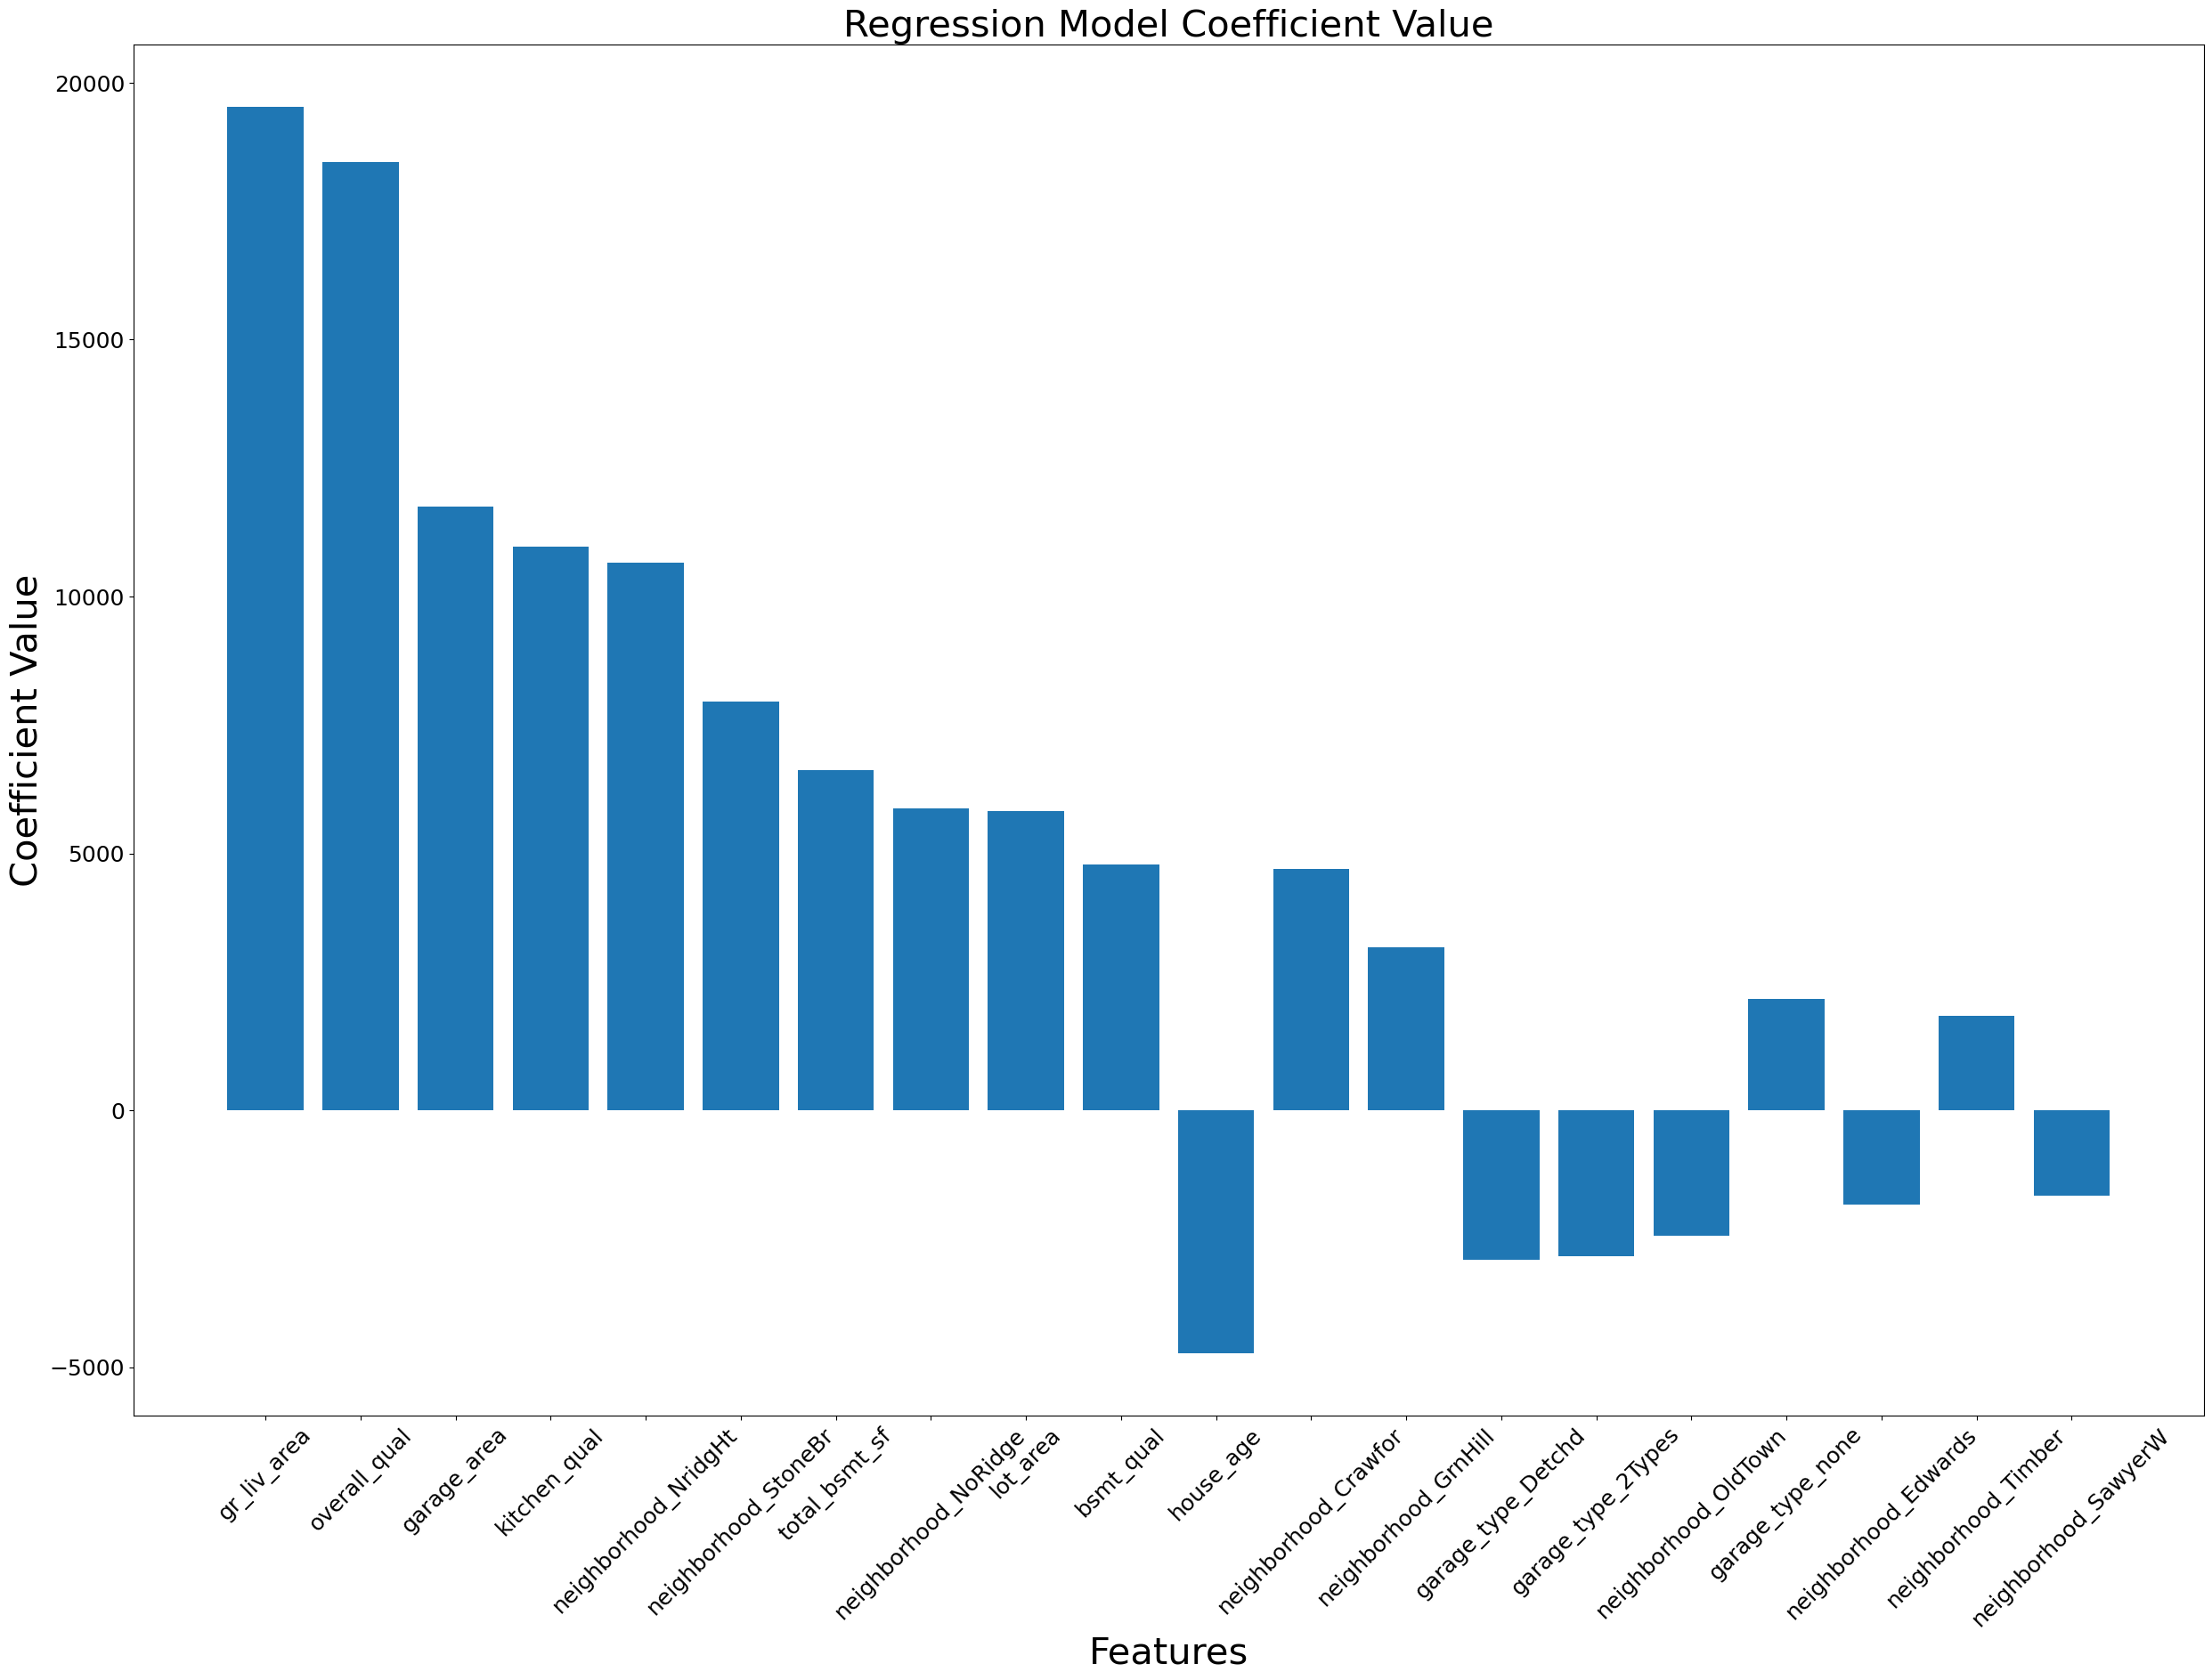

In [51]:
# Plot the coefficent values
plt.rcParams['figure.figsize'] = (30,20)
plt.bar(lasso_coefs["variable"].head(20), lasso_coefs['coef'].head(20))
plt.title('Regression Model Coefficient Value', fontsize = 30)
plt.tick_params(labelsize = 18)
plt.xticks(rotation = 45)
plt.xlabel('Features', fontsize = 30)
plt.ylabel('Coefficient Value', fontsize = 30);

The coefficient value is a measure of the impact that a feature has on predicting the value of the target. More specifically, and in the context of this model, it shows how much a one-unit shift (keeping all other variables constant) in the feature variable changes the predicted sale price. A positive coefficient means that the predicted sale price increases as the value of the feature variable increases. Conversely, a negative coefficient indicates an inverse relationship, with the sale price decreasing as the feature variable increases.

To exemplify, a one unit increment in living area above grade `gr_liv_area` would lead to the predicted sale price increasing by \$19,532.56.

The model has an intercept of 181469 which does not actually make much sense since it implies that a house that does not exist can be sold for minimally $181,469.70. Rather, it acts as a base from which other features in the model add or subtract from to predict the price of a house. 

### Insights
Looking at the coefficients, living area above grade `gr_liv_area`, overall quality `overall_quality`, and garage area `garage_area` have the largest positive contributions to changes in predicted sale price. Which is no surprise since the amount of livable space and the overall build quiality of that space is an important factor in choosing homes. Most households in Ames have around 2 cars which makes the size of a garage of rather high importance too. in fact, not having a garage reduces your predicted sale price.

Some neighborhoods have a relatively stronger impact on sale price. Stonebrook and Northrigdge Heights have the highest positive coefficients among the neighborhoods, reaffirming a trend seen earlier during EDA. These two neighborhoods are near to Iowa State University, where a large of proportion of the Ames population attend school and also have malls, banks, and recreational features nearby. On the flip side there are also neighborhoods, such as Old Town, that have a negative coefficient. The location of a house is thus an important predictor of sale price.

The feature that had the greatest negative effect on sale price is house age `house_age`. Older houses are more likely to have issues and required repairs. This can be quite costly to buyers. The negative coefficient likely reflects a pricing-in of these risks that buyers take on when they purchase an older house.


### Recommendations
Recommendations for agents to identify higher value houses:
1. Location is important, as always. houses in good neighborhoods sell for more. 
2. Use built-up size as a gauge rather than total lot size. Having more livable area above ground or a larger garage seems to impact selling price more than just how big the lot area is.
3. Look out for the overall quality of materials and finishing of a house.  

Recommendations to increase house value before listing:
1. Improving the overall quality of the house just prior to selling might be feasible, as finishings such as painting, flooring, plastering or minor woodwork can be done on short notice. If done sufficiently, you might be rewarded with \$18,000 more.
2. Upgrading your kitchen is another viable option and could potentially net you almost $11,000 more for starters.
3. Some of the stronger factors that impact sale prices (built-up area, garage size) may be costly and time consuming to pursue. May not be worth your while.

### Future Direction

The model is in its current form is able to predict housing prices relatively well. The insights it gives are also actionable to an extent. The current dataset on which the model is trained on is pretty robust, and the model could likely take on more features to increase its predictive value. Perhaps the use of more computationally expensive feature selection methods (such as recursive feature selection) could be applied on the entire dataset to include more features in the model. Lasso regression is able to filter out noise and will likely work well with more features as required.

The model could also perhaps integrate macro-economic data to further strengthen its predictive capabilities during the various phases of the economic cycle. 